In [1]:
import os
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from main import extract_rally_output, high_avail_fld, all_in_one_fld, \
    get_experiment_data_bars

In [2]:
def error_to_human(error_list):
    if len(error_list) == 0:
        return None
    if re.compile('Quota exceeded for instances').search(error_list[2]):
        return "NOVA: Quota exceeded for instance"
    if re.compile('executer._rebuild_server').search(error_list[2]):
        return "NOVA: Rebuild server error"
    if re.compile('Quota exceeded.*router').search(error_list[2]):
        return "NEUTRON: Quota exceeded for router"
    if re.compile('Quota exceeded.*security_group').search(error_list[2]):
        return "NEUTRON: Quota exceeded for security group"
    if re.compile(' Maximum number of volumes allowed \(10\) exceeded for quota').search(error_list[2]):
        return "CINDER: Quota exceeded for volume"
    if re.compile('Unable to establish connection to http://130.149.249').search(error_list[2]):
        #return "CONNECTION_ERROR: Unreachable node,"
        if "admin_keystone.create_user()" in error_list[2]:
            return "CONNECTION_ERROR: Node is unreachable create user"
        if "add_role(user_id=self.executer.user.id" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, add role"
        if "_create_security_group" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, security group"
        if "revoke_role" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, revoke role"
        if "delete_user" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, delete user"
        if "delete_role" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, delete role"
        if "detach_volume" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, detach volume"
        if "create_role" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, create role"
        if "attach_volume" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, attach volume"
        return "CONNECTION_ERROR: Unreachable node,"
    if re.compile('http://130.149.249.*timed out').search(error_list[2]):
        #return "CONNECTION_ERROR: Unreachable node,"
        if "admin_keystone.create_user()" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, create user"
        if "add_role(user_id=self.executer.user.id" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, add role"
        if "_create_security_group" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, security group"
        if "revoke_role" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, revoke role"
        if "delete_user" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, delete user"
        if "delete_role" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, delete role"
        if "detach_volume" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, detach volume"
        if "create_role" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, create role"
        if "attach_volume" in error_list[2]:
            return "CONNECTION_ERROR: Unreachable node, attach volume"
        return "CONNECTION_ERROR: Unreachable node,"
    if re.compile('self.executer.create_volume_params').search(error_list[2]):
        return "CINDER: Create volume"
    if re.compile('Invalid volume: Volume status must be').search(error_list[2]):
        return "CINDER: Invalid volume"
    if re.compile('Cannot.*detach.*while it is in task_state rebuild').search(error_list[2]):
        return "NOVA: Detach volume"
    if re.compile('Cannot.*detach.*while it is in vm_state error').search(error_list[2]):
        return "NOVA: Detach volume"
    if re.compile('self.executer.server_kwargs').search(error_list[2]):
        return "NOVA: Create server"
    if re.compile('download.cirros-cloud.net.*Network is unreachable').search(error_list[2]):
        return "NETWORK_ERROR: Unable to download image"
    if re.compile('cirros-0.3.5-x86_64-disk.img.*Connection refused').search(error_list[2]):
        return "NETWORK_ERROR: Unable to download image"
    if re.compile('cirros-0.3.5-x86_64-disk.img.*Connection timed out').search(error_list[2]):
        return "NETWORK_ERROR: Unable to download image"
    if re.compile('cirros-0.3.5-x86_64-disk.img.*No route to host').search(error_list[2]):
        return "NETWORK_ERROR: Unable to download image"
    print(error_list[2])
    raise Exception(error_list)


def get_error_info(task_data, concurrency, fail_point = None):
    task_data = pd.DataFrame(task_data[0], columns= ["timestamp", "duration", "error", "atomic_actions"])
    error = task_data['error']
    error_formated = error.apply(lambda x: error_to_human(x))
    error_info = {}
    amount_of_errors_per_wl = error_formated.apply(lambda x: x == None)
    failed_workloads = error_formated[~error_formated.isnull()]
    amount_of_errors = failed_workloads.index.size
    success_workloads = error_formated[error_formated.isnull()]
    amount_of_success = success_workloads.index.size
    last_success_index = success_workloads.index[-1]
    if not fail_point:
        fail_point = last_success_index

    failed = False

    first_error = None
    first_error_index = None
    last_error_before_fail = None
    last_error_before_fail_index = None
    error_amount_before_fail = None
    success_amount_before_fail = None
    first_error_after_fail = None
    first_error_after_fail_index = None
    last_error_amount_before_fail = None

    if amount_of_errors > 0:
        if last_success_index+concurrency <= failed_workloads.index[-1]:
            failed = True
    errors_before_fail = None
    errors_after_fail = None
    if failed_workloads.size > 0:
        first_error_index = failed_workloads.index[0]
        first_error = failed_workloads[first_error_index]
    if failed:
        errors_before_fail_index = failed_workloads.index[failed_workloads.index <= fail_point]
        errors_before_fail = failed_workloads[errors_before_fail_index]
        error[errors_before_fail_index].apply(lambda x: error_to_human(x))
        errors_after_fail_index = failed_workloads.index[failed_workloads.index > fail_point]
        errors_after_fail = failed_workloads[errors_after_fail_index]

        last_error_before_fail_index = errors_before_fail_index[-1]
        last_error_before_fail = failed_workloads[last_error_before_fail_index]
        last_error_amount_before_fail = errors_before_fail[errors_before_fail==last_error_before_fail].count()

        error_amount_before_fail = errors_before_fail_index.size
        success_amount_before_fail = success_workloads.size

        first_error_after_fail_index = failed_workloads.index[failed_workloads.index > fail_point][0]
        first_error_after_fail = failed_workloads[first_error_after_fail_index]

    error_info.update({'first_error':first_error, 'first_error_index':first_error_index })
    error_info.update({'last_error_before_fail':last_error_before_fail, "last_error_before_fail_index":last_error_before_fail_index})
    error_info.update({'last_error_amount_before_fail': last_error_amount_before_fail})
    error_info.update({"error_amount_before_fail":error_amount_before_fail })
    error_info.update({"success_amount_before_fail":success_amount_before_fail})
    error_info.update({"first_error_after_fail":first_error_after_fail, "first_error_after_fail_index":first_error_after_fail_index})

    unique_errors = error_formated.dropna().unique()
    error_stat = pd.DataFrame()
    error_data = list()
    for unique_error in unique_errors:
        before_occ = None
        before_occ_perc = None
        after_occ = None
        after_occ_perc = None
        total_occ = error_formated[error_formated == unique_error].count()
        total_occ_perc = (total_occ/error_formated.count()) * 100
        if failed:
            before_occ = errors_before_fail[errors_before_fail==unique_error].count()
            before_occ_perc = (before_occ/errors_before_fail.count())*100
            after_occ = errors_after_fail[errors_after_fail==unique_error].count()
            after_occ_perc = (after_occ/errors_after_fail.count())*100
        curr_stat = {"Total occurence":total_occ, "Total occurence perc.":total_occ_perc,
                     "Before failed occurence": before_occ, "Before failed occurence perc.": before_occ_perc,
                     "After failed occurence": after_occ, "After failed occurence perc.": after_occ_perc}
        error_stat[unique_error] = curr_stat
    if failed:
        error_data = [errors_before_fail, errors_after_fail]
    else:
        error_data = [failed_workloads]
    return error_info, error_stat, error_data

In [3]:
concurrency_list = [1,2,4,8,16,64]
AiO_iteration_to_use=[1,4,1,4,2,1]
AiO_failure_point = [None, None, None, 1064, 11, 2620]
HA_error_info = pd.DataFrame()
AiO_error_info = pd.DataFrame()
HA_error_stats = list()
AiO_error_stats = list()
HA_error_data = list()
AiO_error_data = list()
cached = False
if cached:
    HA_error_info = pd.read_csv("tmp/HA_error.csv", index_col=0)
    AiO_error_info = pd.read_csv("tmp/AiO_error.csv", index_col=0)
    for i in range(6):
        HA_error_stats.append(pd.read_csv(f"tmp/HA_stat{i}.csv", index_col=0))
        AiO_error_stats.append(pd.read_csv(f"tmp/AiO_stat{i}.csv", index_col=0))
else:
    for scenario_counter in range(6):
        conc = concurrency_list[scenario_counter]
        HA_data = extract_rally_output(high_avail_fld, conc)
        AiO_data = extract_rally_output(all_in_one_fld, conc, AiO_iteration_to_use[scenario_counter])
        error_info, error_stats, error_data = get_error_info(HA_data, conc)
        HA_error_info = pd.concat([HA_error_info, pd.DataFrame([error_info])], ignore_index=True)
        HA_error_stats.append(error_stats)
        HA_error_data.append(error_data)
        error_info, error_stats, error_data = get_error_info(AiO_data, conc, AiO_failure_point[scenario_counter])
        AiO_error_info = pd.concat([AiO_error_info, pd.DataFrame([error_info])], ignore_index=True)
        AiO_error_stats.append(error_stats)
        AiO_error_data.append(error_data)

    if not os.path.exists("tmp"):
        os.mkdir("tmp")
    HA_error_info.to_csv("tmp/HA_error.csv")
    AiO_error_info.to_csv("tmp/AiO_error.csv")
    for index in range(6):
        HA_error_stats[index].to_csv(f"tmp/HA_stat{index}.csv")
        AiO_error_stats[index].to_csv(f"tmp/AiO_stat{index}.csv")
config_list = ["Mult", "AiO"]
concurrencies=[1,2,4,8,16,64]
total_data = pd.DataFrame()
for i, data in enumerate(HA_error_stats):
    if i > 2:
        total_data = total_data.add(data, fill_value=0)
for i, data in enumerate(AiO_error_stats):
    if i > 2:
        total_data = total_data.add(data, fill_value=0)
print("done")

done


In [4]:
exp6_bars = get_experiment_data_bars(high_avail_fld, 64, 1, 20)
HA_bars = list()
AiO_bars = list()
for i in range(6):
    HA_bars.append(get_experiment_data_bars(high_avail_fld, concurrency_list[i], 1, 20))
    AiO_bars.append(get_experiment_data_bars(all_in_one_fld, concurrency_list[i], AiO_iteration_to_use[i], 20))

In [5]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'][0] = 12

In [6]:
HA_data = extract_rally_output(high_avail_fld, 64)
temp = get_error_info(HA_data, 64)
print (temp)

({'first_error': 'NEUTRON: Quota exceeded for security group', 'first_error_index': 9, 'last_error_before_fail': 'NEUTRON: Quota exceeded for security group', 'last_error_before_fail_index': 43213, 'last_error_amount_before_fail': 40509, 'error_amount_before_fail': 40704, 'success_amount_before_fail': 2511, 'first_error_after_fail': 'NEUTRON: Quota exceeded for security group', 'first_error_after_fail_index': 43215},                                NEUTRON: Quota exceeded for security group   
Total occurence                                              94340.000000  \
Total occurence perc.                                           91.537133   
Before failed occurence                                      40509.000000   
Before failed occurence perc.                                   99.520932   
After failed occurence                                       53831.000000   
After failed occurence perc.                                    86.325732   

                               NEUTRON:

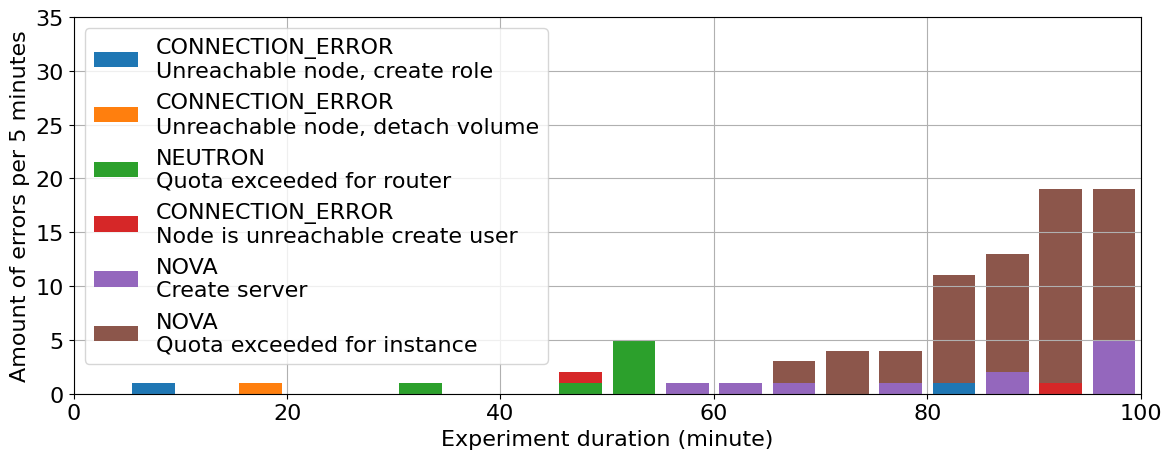

In [17]:
def plot_error_data(bars, error, save_file=None):
    concurrency_list = [1, 2, 4, 8, 16, 64]
    AiO_iteration_to_use = [1, 4, 1, 4, 2, 1]

    error = error[0]
    unique_errors = error.dropna().unique()
    c = list()
    for er in unique_errors:
        if "Quota exceeded for security" not in er:
            c.append(er)
    unique_errors = c

    bar_error = {}

    for unique_error in unique_errors:
        bar_error[unique_error] = list()

    for bar_index in bars.index:
        start_index = bars['start_index'][bar_index]
        end_index = bars['end_index'][bar_index]
        errors_in_bar = error.iloc[(error.index>=start_index) & (error.index<= end_index)]
        for unique_error in unique_errors:
            bar_error[unique_error].append(int(errors_in_bar[errors_in_bar==unique_error].count()))
    y_offset = np.zeros(bars['hour'].size)
    for unique_error in unique_errors:
        if sum(bar_error[unique_error]) == 0:
            continue
        label = unique_error.split(":")[0]+"\n"+unique_error.split(":")[1][1:]
        plt.bar(x=bars['hour']*5, height= bar_error[unique_error], bottom=y_offset, label=label, width=4)
        plt.ylabel("Amount of errors per 5 minutes")
        plt.xlabel("Experiment duration (minute)")
        y_offset = y_offset + bar_error[unique_error]
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.ylim((0,35))
    plt.xlim((0,100))
    if save_file:
        fig = plt.gcf()
        fig.savefig(f'fig/{save_file}', dpi=fig.dpi)
    plt.show()

def plot_error_data_all(HA_error_data, AiO_error_data, HA_bars, AiO_bars):
    plot_error_data(AiO_bars[5][0][0][0:24], AiO_error_data[5], "AiO_64_errors.pdf")
    return
    plot_error_data(HA_bars[5][0][0], HA_error_data[5], "HA_64_errors.pdf")
    for i in range (6):
        plot_error_data(HA_bars[i][0][0], HA_error_data[i], None)
    for i in range (6):
        plot_error_data(AiO_bars[i][0][0], AiO_error_data[i], None)

plot_error_data_all(HA_error_data, AiO_error_data, HA_bars, AiO_bars)